# **DIDN Training**

This implementation is based on [https://github.com/SonghyunYu/DIDN](https://github.com/SonghyunYu/DIDN)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Patch Generator

It is formed on the basis of architecture input requirement of size 64$\times$64$\times$3 with stride 64 (no overlap) according to the reference of authors implemetation.

In [ ]:
import cv2
import numpy as np
import glob
def gen_patch(img_list):
    Patch = []
    patch_size = 64
    stride = 64
    n = len(img_list)
    print(n)
    for i in range(n):
        img = cv2.imread(img_list[i])
        for p in range(0, img.shape[0] - patch_size+1, stride):
            for q in range(0, img.shape[1] - patch_size+1, stride):
                height_slice = slice(p, p+patch_size)
                width_slice = slice(q, q+patch_size)
                patch = img[height_slice, width_slice, :]
                Patch.append(patch)           
                
    return np.array(Patch)  



Training and validation patches are extracted in order to do fair testing for training the architecture.

In [ ]:
train_path = '/content/drive/My Drive/BSR_bsds500/BSR/BSDS500/data/images/train'
train_file_list = glob.glob(train_path+'/*.jpg')

val_path = '/content/drive/My Drive/BSR_bsds500/BSR/BSDS500/data/images/val'
val_file_list = glob.glob(val_path+'/*.jpg')            
        
Train_patch = gen_patch(train_file_list)
Val_patch = gen_patch(val_file_list)

200
100


## DIDN Model

In [ ]:
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, add, concatenate
from keras.optimizers import Adam, SGD
import time, math
from keras import Model
from keras.preprocessing.image import ImageDataGenerator

The class ```DIDN_model``` is based on author github code in order to get the better insight about layers and sub module presented in DIDN architecture



In [ ]:
class DIDN_model(tf.Module):
  def __init__(self, input_shape, upsampling_factor=2):
    super(DIDN_model,self).__init__()
    self.input_shape = input_shape
    self.upsampling_factor = upsampling_factor 
    self.optimizer = optimizers.Adam(lr=0.0001) # Setting up Optimiser   

  def SubpixelConv2D(self):
    def conv_output(ip):  
      output = tf.nn.depth_to_space(ip, self.upsampling_factor)
      return output
    return conv_output 

  # DUB block
  def DUB_block(self, x):
    # x is input to DUB
    x1 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x2 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x1)
    # add1, concat1

    x3 = add([x, x2])
    x4 = Conv2D(512, (3, 3), padding='same', strides=(2, 2), activation='relu')(x3)
    x5 = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(x4)
    # add2, concat2

    x6 = add([x4,x5])
    x7 = Conv2D(1024, (3, 3), padding='same', strides=(2, 2), activation='relu')(x6)
    x8 = Conv2D(1024, (3, 3), padding='same', strides=(1, 1), activation='relu')(x7)
    # add3

    x9 = add([x7,x8])
    x10 = Conv2D(2048, (1, 1), strides=(1, 1))(x9)
    x11 = self.SubpixelConv2D()(x10)

    # concat with concat2
    x12 = concatenate([x11,x5])
    x13 = Conv2D(512, (1, 1), strides=(1, 1))(x12)
    x14 = Conv2D(512, (3, 3), padding='same', strides=(1, 1), activation='relu')(x13)
    # add4

    x15 = add([x13,x14])
    x16 = Conv2D(1024, (1, 1), strides=(1, 1))(x15)
    x17 = self.SubpixelConv2D()(x16)

    # concat with concat1
    x18 = concatenate([x17,x2])
    x19 = Conv2D(256, (1, 1), strides=(1, 1))(x18)
    x20 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x19)
    x21 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x20)
    # add5

    x22 = add([x21,x19])
    x23 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x22)
    # add6

    a = add([x23,x])
    
    return a

  # Recon block
  def Recon(self,x):
    # x is input to Recon
    x1 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x2 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x1)

    add1 = add([x2,x])
    
    x3 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(add1)
    x4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x3)

    add2 = add([x4, add1])

    x5 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(add2)
    x6 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x5)

    add3 = add([x6, add2])

    x7 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(add3)
    x8 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x7)

    add4 = add([x8,add3])

    x9 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='linear')(add4)

    a = add([x9,x])
    
    return a

  # DIDN
  def make_model(self):  
    # x is input to DIDN architecture

    x = Input(self.input_shape)
    x1 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x)
    x2 = Conv2D(256, (3, 3), padding='same', strides=(2, 2), activation='relu')(x1)

    d1 = self.DUB_block(x2)
    d2 = self.DUB_block(d1)
    d3 = self.DUB_block(d2)
    d4 = self.DUB_block(d3)
    d5 = self.DUB_block(d4)
    d6 = self.DUB_block(d5)

    r1 = self.Recon(d1)
    r2 = self.Recon(d2)
    r3 = self.Recon(d3)
    r4 = self.Recon(d4)
    r5 = self.Recon(d5)
    r6 = self.Recon(d6)

    r_cat = concatenate([r1,r2,r3,r4,r5,r6])

    x3 = Conv2D(256, (1, 1), strides=(1, 1))(r_cat)
    x4 = Conv2D(256, (3, 3), padding='same', strides=(1, 1), activation='relu')(x3)

    x5 = self.SubpixelConv2D()(x4)
    x6 = Conv2D(3, (3,3), padding='same', strides=(1, 1))(x5)

    out = add([x6,x])
    model = Model(inputs=[x], outputs=[out])
    model.compile(optimizer=self.optimizer, loss='mae', metrics=[PSNR]) # In the paper, L1 loss is used for training

    return model


In [ ]:
import tensorflow as tf
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1)

### Loading the model

In [ ]:
input_shape = (64,64,3)
model = DIDN_model(input_shape).make_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 256)  7168        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 256)  590080      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 256)  590080      conv2d_1[0][0]                   
_______________________________________________________________________________________

## Batch Generator



Due to CPU memory constraints, keras ```ImageDataGenerator``` have been used with random rotation and flip with batch size 16 (referred from the paper). Noise is generated randomly between $\sigma$ = [5, 50] in order to match best possible general scenario.

In [ ]:
def noise_gen(cleanImg, batch_size = 16, rot = 30, vertical_flip = True):
  generator = ImageDataGenerator(rotation_range = rot, vertical_flip = vertical_flip, fill_mode = 'nearest')
  for batch in generator.flow(x = cleanImg, batch_size = batch_size, seed = 3 ):
    sigma = np.random.randint(5,50)
    AWG_noise = np.random.normal(0.0, sigma/255.0, batch.shape)
    noisyImg_batch = batch/255.0 + AWG_noise
    Target_batch = batch/255.0
    yield (noisyImg_batch,Target_batch)

## Data Loading

Augmentation is employed on Training data. But, random rotation and flip are not used in validation, it only extracts the batches of validation patch. 

In [ ]:
train_dataloader = noise_gen(Train_patch, batch_size = 16, rot = 30, vertical_flip = True)
val_dataloader = noise_gen(Val_patch, batch_size = 16, rot = 0, vertical_flip = False)

## Training Preparation

Creating directory for logging the training details and saving the 
trained model to the drive or folder.

In [ ]:
import os
def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

path = '/content/drive/My Drive/BSR_bsds500'
# Name experiment
experiment_name = "exp-2"
log_path = os.path.join(path,"log", experiment_name)
# Make directory
create_directory(log_path)
print(log_path)

/content/drive/My Drive/BSR_bsds500/log/exp-2


Checking the GPU availability for the training

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Training

In [ ]:
LR = 1e-4   # 1e-4(0.0001) 
EPOCHS = 12
batch_size = 16

# Define callbacks for learning rate scheduling, logging and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('{}/{}.h5'.format(log_path, experiment_name), monitor='PSNR', save_best_only=True, mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='PSNR', factor=0.5, verbose=1, patience=3, mode='max'), ## new_lr = lr * factor # 5
    keras.callbacks.EarlyStopping(monitor='PSNR', min_delta=0, verbose=1, patience=5, mode='max', restore_best_weights=True), # 8
    keras.callbacks.CSVLogger('{}/training.csv'.format(log_path))
]

start_time = time.time()

history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(Train_patch)*3//batch_size,
    epochs=EPOCHS, 
    callbacks=callbacks,
    verbose=1,
    validation_data=val_dataloader, 
    validation_steps=len(Val_patch)//batch_size
)

end_time = time.time()
print("--- Time taken to train : %s hours ---" % ((end_time - start_time)//3600))


Epoch 1/12
1312/1312 [==============================] - 1416s 1s/step - loss: 0.0393 - PSNR: 27.1839 - val_loss: 0.0330 - val_PSNR: 28.0017
Epoch 2/12
1312/1312 [==============================] - 1455s 1s/step - loss: 0.0246 - PSNR: 30.7012 - val_loss: 0.0287 - val_PSNR: 29.3514
Epoch 3/12
1312/1312 [==============================] - 1444s 1s/step - loss: 0.0224 - PSNR: 31.5677 - val_loss: 0.0251 - val_PSNR: 30.6757
Epoch 4/12
1312/1312 [==============================] - 1448s 1s/step - loss: 0.0213 - PSNR: 32.0435 - val_loss: 0.0266 - val_PSNR: 30.0305
Epoch 5/12
1312/1312 [==============================] - 1440s 1s/step - loss: 0.0203 - PSNR: 32.5000 - val_loss: 0.0244 - val_PSNR: 30.8686
Epoch 6/12
1312/1312 [==============================] - 1436s 1s/step - loss: 0.0199 - PSNR: 32.6687 - val_loss: 0.0247 - val_PSNR: 30.7585
Epoch 7/12
1312/1312 [==============================] - 1437s 1s/step - loss: 0.0190 - PSNR: 33.0882 - val_loss: 0.0234 - val_PSNR: 31.3430
Epoch 8/12
1312/1312

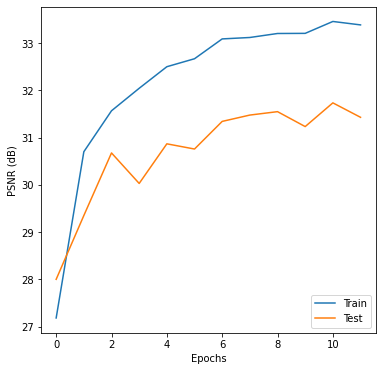

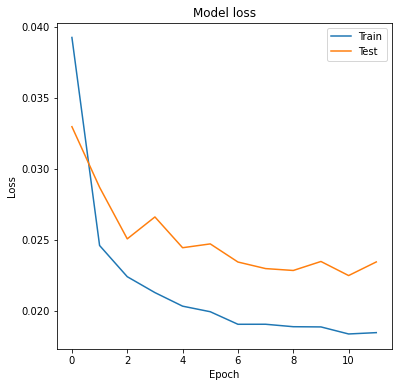

In [ ]:
# Plot training & validation PSNR values
import matplotlib.pyplot as plt
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['PSNR'])
plt.plot(history.history['val_PSNR'])
#plt.title('Model Dice Metric')
plt.ylabel('PSNR (dB)')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()
